# Chapter 4c: Gradient descent & back-propagation for an ANN

It is time to build your first neural network from scratch, which will have one hidden layer. The core concept of model training remains the same as in chapter 4b. It is only the architecture (array operations) which becomes more complex. We will again apply the defined model to the Ionosphere data, and finally compare with the results obtained with only one artificial neuron.

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. The Ionosphere dataset

Find more details about this dataset in chapter 4b. We will use it as input for our ANN model.

In [2]:
# import data
data_df = pd.read_csv('ionosphere_data.txt', header = None)

data_df.rename(columns={34: 'label'}, inplace = True)
data_df['label'].astype('category')
data_df['label'].replace({'g': 1, 'b': 0}, inplace = True)

y = data_df['label'].values
data_df.drop('label', inplace = True, axis = 1)
X = data_df.values

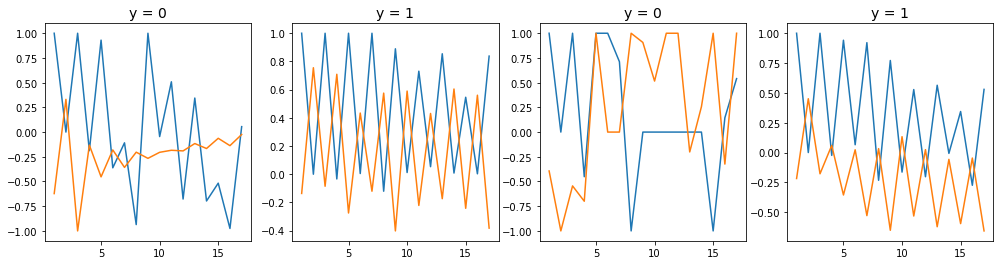

In [3]:
# plot data
Xi = np.arange(1, 17+1, 1)

fig, ax = plt.subplots(1, 4, figsize=(17, 4))
for axi, i in zip(ax, range(1, 5)):
    axi.plot(Xi, X[i, 0:16+1])
    axi.plot(Xi, X[i, 17:33+1])
    axi.set_title('y = {0}'.format(y[i]), size = 14)

**EXERCISE 1:** First split the data into training and test sets by copy pasting the result of exercise 7 in the previous notebook. Then reshape your data by copy pasting the result of exercise 8.

In [4]:
#YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 7)



m_train = np.shape(X_train)[0]
m_test = np.shape(X_test)[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

Number of training examples: m_train = 280
Number of testing examples: m_test = 71


In [5]:
#YOUR CODE HERE
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape((1,m_train))
y_test = y_test.reshape((1,m_test))

## 2. ANN from scratch

Recall that for one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a neural network is to:

    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You will build helper functions to compute steps 1-3 and then merge them into one function we call `ANN_model()`. Once you've built `ANN_model()` and learnt the right parameters, you can make predictions on new data.

### 2.1. Neural network structure

**EXERCISE 2:** Define three variables:

    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set to an adhoc value of 4) 
    - n_y: the size of the output layer

In [6]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    #YOUR CODE HERE (≈ 3 lines of code)
    n_x = np.shape(X)[0]
    n_h = 4
    n_y = 1

    return (n_x, n_h, n_y)

In [7]:
(n_x, n_h, n_y) = layer_sizes(X_train, y_train)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 34
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


### 2.2. Model parameter initialization

**EXERCISE 3**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network characteristics above.
- You will initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    #YOUR CODE HERE (≈ 4 lines of code)
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [9]:
parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-4.16757847e-03 -5.62668272e-04 -2.13619610e-02  1.64027081e-02
  -1.79343559e-02 -8.41747366e-03  5.02881417e-03 -1.24528809e-02
  -1.05795222e-02 -9.09007615e-03  5.51454045e-03  2.29220801e-02
   4.15393930e-04 -1.11792545e-02  5.39058321e-03 -5.96159700e-03
  -1.91304965e-04  1.17500122e-02 -7.47870949e-03  9.02525097e-05
  -8.78107893e-03 -1.56434170e-03  2.56570452e-03 -9.88779049e-03
  -3.38821966e-03 -2.36184031e-03 -6.37655012e-03 -1.18761229e-02
  -1.42121723e-02 -1.53495196e-03 -2.69056960e-03  2.23136679e-02
  -2.43476758e-02  1.12726505e-03]
 [ 3.70444537e-03  1.35963386e-02  5.01857207e-03 -8.44213704e-03
   9.76147160e-08  5.42352572e-03 -3.13508197e-03  7.71011738e-03
  -1.86809065e-02  1.73118467e-02  1.46767801e-02 -3.35677339e-03
   6.11340780e-03  4.79705919e-04 -8.29135289e-03  8.77102184e-04
   1.00036589e-02 -3.81092518e-03 -3.75669423e-03 -7.44707629e-04
   4.33496330e-03  1.27837923e-02 -6.34679305e-03  5.08396243e-03
   2.16116006e-03 -1.85861239e-02 -4

### 2.3. Foreward propagation step

**EXERCISE 4:** Implement `forward_propagation()`.

**Instructions**:

- Look above at the mathematical representation of your classifier.
- You can use the functions `np.tanh()` and `sigmoid()`.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `par_name = parameters["par_name"]`.
    2. Implement forward propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [10]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))    
    return s

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    # Retrieve each parameter from the dictionary "parameters"
    #YOUR CODE HERE (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    #YOUR CODE HERE (≈ 4 lines of code)
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoid(Z2)
        
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [11]:
A2, cache = forward_propagation(X_train, parameters)

print('Z1:', cache['Z1'])
print('A1:', cache['A1'])
print('Z2:', cache['Z2'])
print('A2:', cache['A2'])

Z1: [[-0.05979536 -0.09525646 -0.0981094  ... -0.07756956 -0.10142022
  -0.10643409]
 [-0.00408282 -0.02290798 -0.02471108 ... -0.03726819 -0.01817963
  -0.0160071 ]
 [-0.01525392 -0.00771659 -0.00706056 ... -0.01976117 -0.01266306
  -0.00420571]
 [-0.00588826  0.0021478   0.00089006 ...  0.05375924 -0.05712718
   0.00366433]]
A1: [[-0.0597242  -0.09496939 -0.09779583 ... -0.07741436 -0.10107391
  -0.106034  ]
 [-0.0040828  -0.02290397 -0.02470605 ... -0.03725095 -0.01817763
  -0.01600573]
 [-0.01525274 -0.00771644 -0.00706045 ... -0.0197586  -0.01266238
  -0.00420568]
 [-0.0058882   0.00214779  0.00089006 ...  0.05370751 -0.05706511
   0.00366431]]
Z2: [[ 7.67439090e-04  1.17834315e-03  1.20666834e-03  1.23281928e-03
   1.00686396e-03  4.14089390e-04  3.47376804e-04  6.84371528e-04
   3.92229272e-04  1.01791071e-03  3.59975016e-04  1.10504098e-03
   2.24911641e-04  1.17992889e-04  5.79697135e-04  1.34797887e-03
   9.62742367e-04  7.98033027e-04  1.02739818e-03  6.31691734e-04
   4.661

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function.

**EXERCISE 5**: Implement `compute_cost()` to compute the value of the cost $J = - \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(a,b)
cost = - np.sum(c)
```

In [12]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost
    """
    
    # Compute the cross-entropy cost
    #YOUR CODE HERE (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)
    
    
    cost = np.squeeze(cost)           # eg. turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [13]:
print("cost = " + str(compute_cost(A2, y_train, parameters)))

cost = 122.61606104041485


### 2.4. Backward propagation step

Using the cache computed during forward propagation, you can now implement backward propagation.

**EXERCISE 6:** Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here is the slide from the lecture on backpropagation in Andrew Ng's deep learning course. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="figs_notebook/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

Tips: To compute `dZ1` you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [14]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    
    # number of data samples
    #YOUR CODE HERE (1 line of code)
    m = X.shape[1]
    
    
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    #YOUR CODE HERE (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # Retrieve also A1 and A2 from dictionary "cache".
    #YOUR CODE HERE (≈ 2 lines of code)
    A1 = cache['A1']
    A2 = cache['A2']
    

    
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    #YOUR CODE HERE (≈ 6 lines of code, corresponding to 6 equations on slide above)
    Z1 = cache['Z1']
    dZ2 = A2-Y
    dW2 = 1/m*np.dot(dZ2,A1.T)
    db2 = 1/m*np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T,dZ2)*(1 - np.power(A1, 2))*Z1
    dW1 = 1/m*np.dot(dZ1,X.T)
    db1 = 1/m*np.sum(dZ1, axis = 1,keepdims = True)

        
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [15]:
grads = backward_propagation(parameters, cache, X_train, y_train)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[-2.31428603e-04  0.00000000e+00 -1.93189358e-04 -3.46901136e-05
  -1.81064774e-04 -3.35075257e-05 -1.79782369e-04 -4.08863604e-05
  -1.42773892e-04 -3.31043929e-05 -1.39321628e-04 -5.25088719e-05
  -1.35402924e-04 -6.90029814e-06 -1.31408007e-04 -7.18322988e-06
  -1.19236777e-04  7.45029177e-06 -1.05770964e-04  1.85147004e-05
  -1.37093367e-04  4.77542704e-05 -1.31970137e-04  2.86384193e-05
  -1.38791485e-04  3.48706687e-05 -1.38397918e-04  4.03274927e-05
  -1.29989157e-04  6.73272753e-06 -1.42987455e-04 -1.96195557e-06
  -1.26025345e-04  1.01682182e-05]
 [ 9.86164103e-06  0.00000000e+00  9.34402952e-06  4.32189855e-06
   7.40971776e-06 -8.01797358e-06  5.60044606e-06 -3.42294113e-06
   1.01166134e-05 -7.48548452e-07  2.38264457e-05 -6.44929301e-06
   1.56175142e-05 -1.35321865e-05  1.23660327e-05 -7.43418414e-06
   2.92819705e-05 -1.62691336e-05  1.86087260e-05 -5.45724354e-06
   2.01566159e-05 -2.23281365e-06  2.68871326e-05  1.61863162e-06
   2.95175895e-05 -1.05488318e-05  

### 2.5. Gradient descent step

**EXERCISE 7:** Implement the update rule by using gradient descent. You have to use (`dW1`, `db1`, `dW2`, `db2`) in order to update (`W1`, `b1`, `W2`, `b2`).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley (shared in Ng's course).

<img src="figs_notebook/sgd.gif" style="width:400;height:400;">
<img src="figs_notebook/sgd_bad.gif" style="width:400;height:400;">

In [16]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    # Retrieve each parameter from the dictionary "parameters"
    #YOUR CODE HERE (≈ 4 lines of code)
    W1 =parameters['W1']
    b1 =parameters['b1']
    W2 =parameters['W2']
    b2 =parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    #YOUR CODE HERE (≈ 4 lines of code)
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    
    # Update rule for each parameter
    #YOUR CODE HERE (≈ 4 lines of code)
    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2
    
    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [17]:
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-3.88986415e-03 -5.62668272e-04 -2.11301337e-02  1.64443362e-02
  -1.77170781e-02 -8.37726463e-03  5.24455301e-03 -1.24038172e-02
  -1.04081935e-02 -9.05035088e-03  5.68172640e-03  2.29850908e-02
   5.77877438e-04 -1.11709741e-02  5.54827281e-03 -5.95297712e-03
  -4.82208328e-05  1.17410718e-02 -7.35178434e-03  6.80348692e-05
  -8.61656689e-03 -1.62164683e-03  2.72406868e-03 -9.92215659e-03
  -3.22166988e-03 -2.40368511e-03 -6.21047262e-03 -1.19245159e-02
  -1.40561853e-02 -1.54303123e-03 -2.51898466e-03  2.23160222e-02
  -2.41964454e-02  1.11506319e-03]
 [ 3.69261140e-03  1.35963386e-02  5.00735923e-03 -8.44732332e-03
  -8.79404659e-06  5.43314729e-03 -3.14180251e-03  7.71422491e-03
  -1.86930465e-02  1.73127449e-02  1.46481884e-02 -3.34903423e-03
   6.09466678e-03  4.95944543e-04 -8.30619213e-03  8.86023205e-04
   9.96852050e-03 -3.79140221e-03 -3.77902470e-03 -7.38158937e-04
   4.31077536e-03  1.27864717e-02 -6.37905761e-03  5.08202007e-03
   2.12573896e-03 -1.85734653e-02 -4

### 2.6. ANN model build

**EXERCISE 8:** Build your neural network model in `ANN_model()` by combining the functions previously defined.

In [20]:
def ANN_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    #YOUR CODE HERE (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 =parameters['W1']
    b1 =parameters['b1']
    W2 =parameters['W2']
    b2 =parameters['b2']
    
    
    

    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
         
        #YOUR CODE HERE (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A2,cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost"
        cost = compute_cost(A2,Y,parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads"
        grads = backward_propagation(parameters,cache,X,Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters"
        parameters = update_parameters(parameters, grads, learning_rate)
        

        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

**EXERCISE 9:** It is now time to train the model on the Ionosphere dataset! Choose the number of hidden neurons and calculate the parameters.

In [32]:
#YOUR CODE HERE

parameters = ANN_model(X_train, y_train,n_h = 4,num_iterations = 40000, learning_rate = 0.01,print_cost=True)

Cost after iteration 0: 122.616061
Cost after iteration 1000: 84.426809
Cost after iteration 2000: 81.479383
Cost after iteration 3000: 81.169402
Cost after iteration 4000: 81.100987
Cost after iteration 5000: 81.036742
Cost after iteration 6000: 80.892000
Cost after iteration 7000: 78.295401
Cost after iteration 8000: 68.876474
Cost after iteration 9000: 59.042338
Cost after iteration 10000: 52.246410
Cost after iteration 11000: 50.904505
Cost after iteration 12000: 50.548082
Cost after iteration 13000: 50.313608
Cost after iteration 14000: 49.940656
Cost after iteration 15000: 47.802139
Cost after iteration 16000: 44.344942
Cost after iteration 17000: 41.992232
Cost after iteration 18000: 40.715396
Cost after iteration 19000: 39.703603
Cost after iteration 20000: 38.580847
Cost after iteration 21000: 37.292358
Cost after iteration 22000: 35.984202
Cost after iteration 23000: 34.765842
Cost after iteration 24000: 33.632928
Cost after iteration 25000: 32.520983
Cost after iteration 260

### 2.7. Model prediction

**EXERCISE 10:** Is it a good model? Is it better than the logistic regression model developed in chapter 4b? To asnwer, define the function `predict()`. Use forward propagation to predict results.

**Reminder**: $y_{prediction} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

which can be coded with `np.where(X > p, val_TRUE, val_FALSE)`.

In [33]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    #YOUR CODE HERE (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = np.where(A2>0.5,1,0)

    
    
    return predictions

In [34]:
y_pred_train = predict(parameters, X_train)
y_pred_test = predict(parameters, X_test)

accuracy_train = (y_pred_train == y_train).mean()
accuracy_test = (y_pred_test == y_test).mean()
print ("Training set accuracy for {} hidden units: {} %".format(n_h, accuracy_train))
print ("Test set accuracy for {} hidden units: {} %".format(n_h, accuracy_test))

Training set accuracy for 4 hidden units: 0.9107142857142857 %
Test set accuracy for 4 hidden units: 0.9014084507042254 %


_YOUR ANSWER HERE_